# With Synthetic Data

In [1]:
import os
PATH = os.getenv("HOME")
os.chdir(f"{PATH}/watttime-python-client-aer-algo")

import pandas as pd
import evaluation.eval_framework as evu
from datetime import datetime

import seaborn as sns
import evaluation.metrics as m

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")


In [2]:
import random
import math
from watttime import WattTimeForecast, WattTimeHistorical
import data.s3 as s3u

In [3]:
s3 = s3u.s3_utils()

## Analysis Details
- 2024 dates only
- 1000 users
- sanity check on 9 current regions + 9 randomly selected other regions
- set of requery increments to test: none, 5,15,60,180
- charging windows of lengths 3,6,12 hours
- Charge needed at least 45 minutes (25% of smallest window)

### Regions

In [5]:
original_regions = [
    "SPP_TX",
    "ERCOT_EASTTX",
    "FPL",
    "SOCO",
    "PJM_CHICAGO",
    "LDWP",
    "PJM_DC",
    "NYISO_NYC",
]

#from evaluation.config import MOER_REGION_LIST
#random_regions = random.sample([elem for elem in MOER_REGION_LIST if elem not in regions], 9)

random_regions = [
    'PACE',
    'PNM',
    'MISO_INDIANAPOLIS',
    'WALC',
    'SPP_FORTPECK',
    'SPP_KANSAS',
    'AECI',
    'BANC',
    'PJM_SOUTHWEST_OH'
]

regions = original_regions+random_regions

In [6]:
df_req = s3.load_csvdataframe("requery_data/20241203_1k_synth_users_96_days.csv")

<Axes: ylabel='Frequency'>

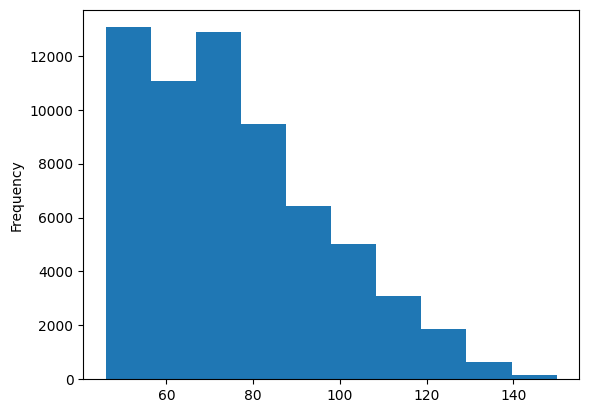

In [7]:
df_req.usage_time_required_minutes.plot(kind='hist')

In [10]:
forecast_generator = WattTimeForecast(username, password)
historical_generator = WattTimeHistorical(username, password)

### Single test

In [73]:
import importlib
importlib.reload(evu)

<module 'evaluation.eval_framework' from '/home/jennifer.badolato/watttime-python-client-aer-algo/evaluation/eval_framework.py'>

In [16]:
def sanitize_time_needed(x,y):
    return int(math.ceil(min(x, y) / 300.0) * 5)

def sanitize_total_intervals(x):
    return math.ceil(x)

In [17]:
optimization_method = "simple"
requery_intervals = [5,15,60,180]
region = "PJM_SOUTHWEST_OH"

full_forecast = s3.load_parquetdataframe(f"complete_2024_forecast_history/{region}.parquet")
full_history = s3.load_parquetdataframe(f"complete_2024_actual_history/{region}.parquet")

In [18]:
# Sanitize input data
df_req["sanitize_intervals_plugged_in"] = df_req.apply(lambda x: sanitize_total_intervals(x.total_intervals_plugged_in), axis=1)
df_req["sanitize_time_needed"] = df_req.apply(lambda x: sanitize_time_needed(x.total_seconds_to_95, x.length_of_session_in_seconds), axis=1)

In [19]:
synth_data = df_req.sample(10)

In [70]:
full_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55488 entries, 0 to 55487
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   point_time  55488 non-null  datetime64[ns, UTC]
 1   value       55488 non-null  float64            
 2   region      55488 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 1.3+ MB


In [20]:
synth_data.session_start_time = pd.to_datetime(synth_data.session_start_time)
synth_data.session_end_time = pd.to_datetime(synth_data.session_end_time)

In [59]:
time_zone = evu.get_timezone_from_dict(region)                    
start_time = pd.Timestamp(evu.convert_to_utc(synth_data.iloc[0]['session_start_time'].round('5min') , time_zone))
end_time = pd.Timestamp(evu.convert_to_utc(synth_data.iloc[0]['session_end_time'].round('5min'), time_zone))
time_needed = 50
usage_power_kw = 36.1675

In [74]:
schedules = evu.full_requery_sim(
    region=region,
    full_forecast=full_forecast,
    full_history=full_history,
    increments=requery_intervals,
    start_time=start_time,
    end_time=end_time,
    usage_power_kw=usage_power_kw,
    time_needed=time_needed,
    method="auto",
    charge_per_interval=None
)

== Simple fit! ==
== Simple fit! ==


AssertionError: 

In [68]:
new_start_time < end_time

True

In [66]:
from datetime import timedelta

In [ ]:
curr_fcst_data["point_time"].min()

In [67]:
new_start_time = start_time + timedelta(minutes = 60)

In [64]:
evu.get_schedule_and_cost_api_requerying(
    region,
    usage_power_kw,
    time_needed,
    start_time,
    end_time,
    optimization_method="auto",
    moer_list = None,
    charge_per_interval = None,
    requery_interval_minutes = 60


)

== Simple fit! ==
== Simple fit! ==
== Simple fit! ==


,pred_moer,usage,emissions_co2e_lb,energy_usage_mwh
point_time,,,,
2024-05-27 07:30:00+00:00,1136.9,5.0,3.426569,0.003014
2024-05-27 07:35:00+00:00,1136.9,0.0,0.000000,0.000000
2024-05-27 07:40:00+00:00,1136.0,5.0,3.423857,0.003014
2024-05-27 07:45:00+00:00,1115.4,5.0,3.361769,0.003014
2024-05-27 07:50:00+00:00,1132.4,5.0,3.413006,0.003014
2024-05-27 07:55:00+00:00,1108.3,5.0,3.340370,0.003014
2024-05-27 08:00:00+00:00,1140.4,0.0,0.000000,0.000000
2024-05-27 08:05:00+00:00,1141.9,0.0,0.000000,0.000000
2024-05-27 08:10:00+00:00,1140.8,0.0,0.000000,0.000000
